In [1]:
import numpy as np
import scipy
from scipy.sparse import csr_matrix, issparse
from scipy import sparse
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def construct(n: int):
    def u(x, y):
        return np.sin(np.pi * x) * np.sin(2 * np.pi * y)

    def f(x, y):
        return (5 * np.pi ** 2 + np.exp(x * y)) * u(x, y)

    h = 1 / (n + 1)
    nn = n ** 2
    a = 4 * (n + 1) ** 2
    b = -1 * (n + 1) ** 2

    row = []
    col = []
    elem = []

    xs = np.zeros(shape=(nn, 1))
    ys = np.zeros(shape=(nn, 1))

    for i in range(n):
        for j in range(n):
            k = i + j * n
            x = (i + 1) * h
            y = (j + 1) * h

            row.append(k)
            col.append(k)
            elem.append(a + np.exp(x * y))

            if i >= 1:
                row.append(k)
                col.append(k - 1)
                elem.append(b)
            if i <= n - 2:
                row.append(k)
                col.append(k + 1)
                elem.append(b)

            if j >= 1:
                row.append(k)
                col.append(k - n)
                elem.append(b)
            if j <= n - 2:
                row.append(k)
                col.append(k + n)
                elem.append(b)
            
            xs[k] = x
            ys[k] = y
    return csr_matrix((elem, (row, col)), shape=(nn, nn)), u(xs, ys), f(xs, ys)

In [3]:
def direct_iter(A, max_iter=10000, tol=1e-8, cor_tol=False):
    u1_prev = np.ones(shape=(A.shape[1], 1))
    u1_prev = u1_prev / np.linalg.norm(u1_prev)

    u2_prev = np.ones(shape=(A.shape[1], 1))
    u2_prev = u2_prev / np.linalg.norm(u2_prev)
    
    ev1 = ev1_prev = 0
    ev2 = ev2_prev = 0
    for k in range(max_iter):
        u1 = A @ u1_prev
        ev1 = (u1.T @ u1_prev).ravel()[0]

        if cor_tol:
            u2 = A @ u2_prev - ev1 * (u1.T @ u2_prev).ravel()[0] * u1
            ev2 = (u2.T @ u2_prev).ravel()[0]
            ev2_prev = ev2
            u2_prev = u2 / np.linalg.norm(u2)
            if k > 10 and (ev2 / ev1) ** (2*k) <= tol:
                        break
        else:
            if np.abs(ev1 - ev1_prev) < tol:
                break

        ev1_prev = ev1
        u1_prev = u1 / np.linalg.norm(u1)
    return ev1

In [4]:
def find_minimum(A, max_iter=10000, tol=1e-8):
    alpha = direct_iter(A, max_iter=max_iter, tol=tol)
    ev_min = direct_iter(A - alpha * sparse.eye(A.shape[0]), max_iter=max_iter, tol=tol)
    return ev_min + alpha, alpha

In [5]:
# from tqdm.notebook import tqdm
x = []
y_max = []
y_min = []
q_jacobi = []
q_seidel = []
for n in range(5, 101, 5):
    x.append(n)

    A, _, _ = construct(n)
    D = sparse.diags(A.diagonal())

    min_, max_ = find_minimum(A)
    y_max.append(np.abs(max_))
    y_min.append(np.abs(min_))

    B = A - D
    D_ = sparse.diags(1 / D.diagonal())
    M_jacobi = D_ @ B
    q_jacobi.append(np.abs(direct_iter(M_jacobi)))

    L = sparse.tril(A, k=-1)
    U = sparse.triu(A, k=1).A
    M_seidel = scipy.linalg.inv((D + L).A) @ U
    q_seidel.append(np.abs(direct_iter(M_seidel)))
x = np.array(x) ** 2
y_min = np.array(y_min)
y_max = np.array(y_max)
q_jacobi = np.array(q_jacobi)
q_seidel = np.array(q_seidel)

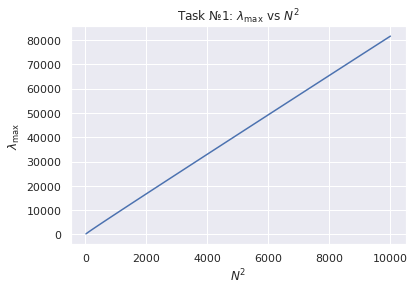

In [6]:
plt.plot(x, y_max)
plt.xlabel("$N^2$")
plt.ylabel("$\\lambda_{\\max}$")
plt.title("Task №1: $\\lambda_{\\max}$ vs $N^2$")
plt.show()

Из графика можно сделать вывод, что масксимальное собственное число растет квадратично с увеличением $N$.

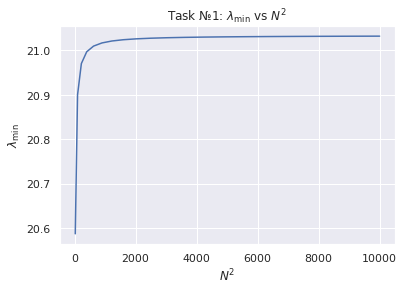

In [7]:
plt.plot(x, y_min)
plt.xlabel("$N^2$")
plt.ylabel("$\\lambda_{\\min}$")
plt.title("Task №1: $\\lambda_{\\min}$ vs $N^2$")
plt.show()

А вот минимальное собственно число выходит на плато.

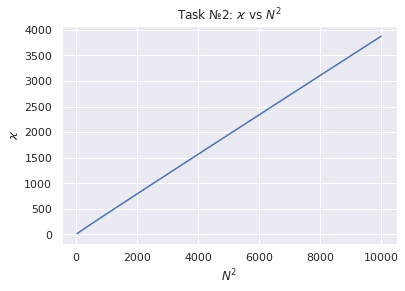

In [8]:
plt.plot(x, y_max / y_min)
plt.xlabel("$N^2$")
plt.ylabel("$\\varkappa$")
plt.title("Task №2: $\\varkappa$ vs $N^2$")
plt.show()

Поэтому неудивительно, что коэффициент обсуловленности также квадратично возрастает

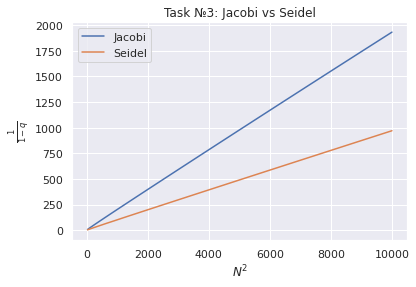

In [9]:
plt.plot(x, 1 / (1 - q_jacobi), label="Jacobi")
plt.plot(x, 1 / (1 - q_seidel), label="Seidel")
plt.xlabel("$N^2$")
plt.ylabel("$\\frac{1}{1 - q}$")
plt.title("Task №3: Jacobi vs Seidel")
plt.legend()
plt.show()

В целом, для данной задачи поведение, что для метода Якоби, что для метода Зейделя, скорее, одинаковое. $1-q$ также с увеличением размера матрицы стремится к $0$, что опять ожидаемо из предыдущих графиков. У зейделя константа чуть-чуть поменьше.